In [ ]:
# Install libraries
%pip install transformers datasets scikit-learn

In [1]:
# Import libraries
import torch
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset, Dataset
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
!wget https://raw.githubusercontent.com/NewReyy/dummy-dataset/refs/heads/main/data%20IKN.csv -O /content/data_IKN.csv

--2025-07-18 01:17:10--  https://raw.githubusercontent.com/NewReyy/dummy-dataset/refs/heads/main/data%20IKN.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 599191 (585K) [text/plain]
Saving to: ‘/content/data_IKN.csv’

/content/data_IKN.c 100%[===================>] 585.15K  3.13MB/s    in 0.2s    

2025-07-18 01:17:10 (3.13 MB/s) - ‘/content/data_IKN.csv’ saved [599191/599191]



In [4]:
# Load dataset
df = pd.read_csv("/content/data_IKN.csv")  # Ganti dengan path file CSV dataset kamu
df['label'] = df['label'].apply(lambda x: 1 if x == 'Positif' else 0)  # Mengubah label menjadi 0 (Negatif) dan 1 (Positif)

In [5]:
# Catatan: Tokenizer digunakan untuk mengubah teks menjadi representasi numerik
# Initialize tokenizer and model
tokenizer = DistilBertTokenizer.from_pretrained("cahya/distilbert-base-indonesian")
model = DistilBertForSequenceClassification.from_pretrained("cahya/distilbert-base-indonesian", num_labels=2)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/62.0 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/473 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/273M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at cahya/distilbert-base-indonesian and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [6]:
# Preprocessing - Tokenize the email messages
def tokenize_function(text):
    # Fungsi untuk men-tokenisasi teks email dan mengubahnya menjadi input untuk model
    return tokenizer(text, padding='max_length', truncation=True, max_length=128, return_tensors="pt")

In [7]:
# Tokenizing email messages
texts = list(df['Komentar'])  # Mengambil semua teks dari kolom 'Pesan'
labels = list(df['label'])  # Mengambil semua label (0 atau 1)
tokenized_texts = [tokenize_function(text) for text in texts]  # Tokenisasi semua teks

model.safetensors:   0%|          | 0.00/273M [00:00<?, ?B/s]

In [8]:
# Prepare input tensors for PyTorch
# Menggabungkan token input dan attention mask menjadi tensor yang siap digunakan untuk training
input_ids = torch.cat([x['input_ids'] for x in tokenized_texts], dim=0)
attention_masks = torch.cat([x['attention_mask'] for x in tokenized_texts], dim=0)
labels = torch.tensor(labels)

In [9]:
# Membagi dataset menjadi data training dan data validasi (80% training, 20% testing)
train_inputs, val_inputs, train_labels, val_labels = train_test_split(input_ids, labels, test_size=0.2)
train_masks, val_masks, _, _ = train_test_split(attention_masks, labels, test_size=0.2)

In [10]:
# Membuat DataLoader untuk mini-batch training dan validation
batch_size = 16

train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = torch.utils.data.RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

validation_data = TensorDataset(val_inputs, val_masks, val_labels)
validation_sampler = torch.utils.data.SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

In [32]:
# Training setup
from torch.optim import AdamW

# Optimizer digunakan untuk mengupdate parameter model selama training
optimizer = AdamW(model.parameters(), lr=2e-5)

In [ ]:
from tqdm import tqdm

epochs = 3
for epoch in range(epochs):
    print(f"\nEpoch {epoch + 1}/{epochs}")
    model.train()

    total_loss = 0

    # Tambahkan tqdm untuk loop training
    train_loop = tqdm(train_dataloader, desc="Training", leave=False)

    for batch in train_loop:
        batch_input_ids, batch_attention_mask, batch_labels = batch

        optimizer.zero_grad()

        outputs = model(input_ids=batch_input_ids, attention_mask=batch_attention_mask, labels=batch_labels)
        loss = outputs.loss
        total_loss += loss.item()

        loss.backward()
        optimizer.step()

        # Update progress bar dengan current loss
        train_loop.set_postfix(loss=loss.item())

    avg_train_loss = total_loss / len(train_dataloader)
    print(f"Average training loss: {avg_train_loss:.4f}")

    # Evaluation
    model.eval()
    correct = 0
    total = 0
    predictions_list = []
    true_labels_list = []

    val_loop = tqdm(validation_dataloader, desc="Validating", leave=False)

    with torch.no_grad():
        for batch in val_loop:
            batch_input_ids, batch_attention_mask, batch_labels = batch
            outputs = model(input_ids=batch_input_ids, attention_mask=batch_attention_mask)
            predictions = torch.argmax(outputs.logits, dim=-1)

            predictions_list.extend(predictions.tolist())
            true_labels_list.extend(batch_labels.tolist())

            correct += (predictions == batch_labels).sum().item()
            total += batch_labels.size(0)

    accuracy = correct / total
    print(f"Validation Accuracy: {accuracy * 100:.2f}%")

Confusion Matrix:
[[101  24]
 [ 53 149]]


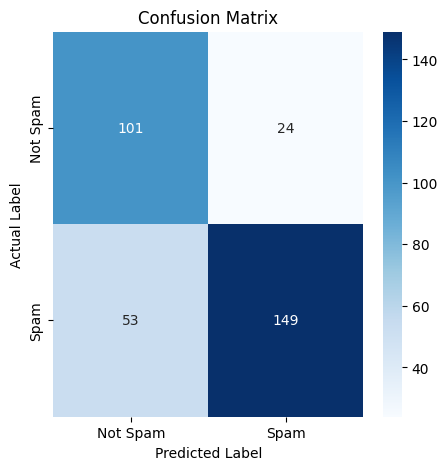

In [15]:
# Confusion Matrix & Evaluation Metrics
cm = confusion_matrix(true_labels_list, predictions_list)
print(f"Confusion Matrix:\n{cm}")

# Plot confusion matrix
plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Negatif', 'Positif'], yticklabels=['Negatif', 'Positif'])
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix')
plt.show()

In [16]:
# Generate and print the classification report
classification_rep = classification_report(true_labels_list, predictions_list, target_names=['Negatif', 'Positif'])
print(f"Classification Report:\n{classification_rep}")

Classification Report:
              precision    recall  f1-score   support

    not spam       0.66      0.81      0.72       125
        spam       0.86      0.74      0.79       202

    accuracy                           0.76       327
   macro avg       0.76      0.77      0.76       327
weighted avg       0.78      0.76      0.77       327



In [23]:
# Save model
from google.colab import drive
drive.mount('/content/drive')

model.save_pretrained("/content/drive/MyDrive/fine_tuned_sentiment_model")
tokenizer.save_pretrained("/content/drive/MyDrive/fine_tuned_sentiment_model")

Mounted at /content/drive


In [6]:
model = DistilBertForSequenceClassification.from_pretrained("/content/drive/MyDrive/fine_tuned_sentiment_model")
tokenizer = DistilBertTokenizer.from_pretrained("/content/drive/MyDrive/fine_tuned_sentiment_model")

In [7]:
# Define a function
def predict_sentimen(text, model, tokenizer):
    # Tokenisasi input teks dan prediksi
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True)
    outputs = model(**inputs)
    probs = outputs.logits.softmax(1)
    return "Positif" if torch.argmax(probs) == 1 else "Negatif"

In [8]:
# Percobaan prediksi apakah pesan adalah spam atau bukan
input_text = 'iKN secepat ini pembangunannya.. kaget gue'
print(predict_sentimen(input_text, model, tokenizer))

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Negatif


In [10]:
# Percobaan prediksi apakah pesan adalah spam atau bukan
input_text = 'Jujur suasana IKN di Sore dan malam tuh syahdu dan cantik bgt woyy,mau main kesana tpi syg jawa barat ke kalimantan lumayan jauh huhu,gda duitðŸ˜'
print(predict_sentimen(input_text, model, tokenizer))

Positif


In [9]:
input_text = 'IKN SAMPAH DAN BUANG-BUANG ANGGARAN NEGARA. NEGARA DAN PEJABAT UDAH KORUPSI MALAH DITAMBAH PROYEK MANGKRAK GAKJELAS!!'
print(predict_sentimen(input_text, model, tokenizer))

Negatif


# Continual Fine Tuning

In [2]:
!wget https://raw.githubusercontent.com/NewReyy/dummy-dataset/refs/heads/main/data%20IKN.csv -O /content/data_IKN.csv

--2025-07-18 05:56:13--  https://raw.githubusercontent.com/NewReyy/dummy-dataset/refs/heads/main/data%20IKN.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 599191 (585K) [text/plain]
Saving to: ‘/content/data_IKN.csv’

/content/data_IKN.c 100%[===================>] 585.15K  --.-KB/s    in 0.009s  

2025-07-18 05:56:13 (60.3 MB/s) - ‘/content/data_IKN.csv’ saved [599191/599191]



In [3]:
df = pd.read_csv("/content/data_IKN.csv")
df.drop(columns=['comment_clean', 'comment_preprocessing', 'comment_DLD'], inplace=True)
df

,Komentar,label
0,teman-temanku abak abah pengen kesana 🥺 bentar...,Positif
1,Akkkhhhhh apaan si IKN NUSANTARA kok seindah i...,Positif
2,rakyat biasa bisa gsii masuk ikn🙂,Positif
3,"Ikn vs gbk dulu waktu pertama kali dibangun ,b...",Positif
4,merinding pengen ikut upacara di IKN 😭,Positif
...,...,...
1629,"waspada saja dgn makam palsu, karna survei na ...",Negatif
1630,masyaallah sudah mulai berubah warnanya ya🥰🥰🥰 ...,Positif
1631,yg gak suka IKN mreka cuma menganggap kalimant...,Negatif
1632,semoga nggak kaya Jakarta wanti wanti batik ka...,Positif


In [4]:
df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)
df

,Komentar,label
0,teman-temanku abak abah pengen kesana 🥺 bentar...,Positif
1,Akkkhhhhh apaan si IKN NUSANTARA kok seindah i...,Positif
2,rakyat biasa bisa gsii masuk ikn🙂,Positif
3,"Ikn vs gbk dulu waktu pertama kali dibangun ,b...",Positif
4,merinding pengen ikut upacara di IKN 😭,Positif
...,...,...
1629,"waspada saja dgn makam palsu, karna survei na ...",Negatif
1630,masyaallah sudah mulai berubah warnanya ya🥰🥰🥰 ...,Positif
1631,yg gak suka IKN mreka cuma menganggap kalimant...,Negatif
1632,semoga nggak kaya Jakarta wanti wanti batik ka...,Positif


## Preprocessing Ulang

In [5]:
!wget https://raw.githubusercontent.com/NewReyy/dummy-dataset/refs/heads/main/kamus.txt -O /content/kamus.txt
!wget https://raw.githubusercontent.com/NewReyy/dummy-dataset/refs/heads/main/slang.csv -O /content/slang.csv

--2025-07-18 05:56:13--  https://raw.githubusercontent.com/NewReyy/dummy-dataset/refs/heads/main/kamus.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6872 (6.7K) [text/plain]
Saving to: ‘/content/kamus.txt’

/content/kamus.txt  100%[===================>]   6.71K  --.-KB/s    in 0s      

2025-07-18 05:56:13 (53.0 MB/s) - ‘/content/kamus.txt’ saved [6872/6872]

--2025-07-18 05:56:13--  https://raw.githubusercontent.com/NewReyy/dummy-dataset/refs/heads/main/slang.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 28887 (28K) [

### Cleaning

In [6]:
import re
import string

def cleaningText(text):
    # menghilangkan url
    text = re.sub(r'https?:\/\/\S+','',text)
    # menghilangkan mention, link, hastag
    text = ' '.join(re.sub("([@#][A-Za-z0-9]+)|(\w+:\/\/\S+)"," ", text).split())
    #menghilangkan karakter byte (b')
    text = re.sub(r'(b\'{1,2})',"", text)
    # menghilangkan yang bukan huruf
    text = re.sub('[^a-zA-Z]', ' ', text)
    # menghilangkan digit angka
    text = re.sub(r'\d+', '', text)
    #menghilangkan tanda baca
    text = text.translate(str.maketrans("","",string.punctuation))
    # menghilangkan whitespace berlebih
    text = re.sub(r'\s+', ' ', text).strip()

    # Memecah teks menjadi kata-kata terpisah
    text = text.split()

    return ' '.join(text)  # Mengembalikan teks yang sudah diproses kembali menjadi string

In [7]:
df['Komentar'] = df['Komentar'].apply(cleaningText)
df

,Komentar,label
0,teman temanku abak abah pengen kesana bentar k...,Positif
1,Akkkhhhhh apaan si IKN NUSANTARA kok seindah ini,Positif
2,rakyat biasa bisa gsii masuk ikn,Positif
3,Ikn vs gbk dulu waktu pertama kali dibangun ba...,Positif
4,merinding pengen ikut upacara di IKN,Positif
...,...,...
1629,waspada saja dgn makam palsu karna survei na s...,Negatif
1630,masyaallah sudah mulai berubah warnanya ya sed...,Positif
1631,yg gak suka IKN mreka cuma menganggap kalimant...,Negatif
1632,semoga nggak kaya Jakarta wanti wanti batik ka...,Positif


### Slangword

In [8]:
kamus_normalisasi = pd.read_csv("/content/slang.csv")

kata_normalisasi_dict = {}

for index, row in kamus_normalisasi.iterrows():
    if row[0] not in kata_normalisasi_dict:
        kata_normalisasi_dict[row[0]] = row[1]

def normalisasi_kata(document):
    document = str(document)
    tokens = document.split()
    normalized_tokens = [str(kata_normalisasi_dict.get(term, term)) for term in tokens]
    return ' '.join(normalized_tokens)

/tmp/ipython-input-8-3395332397.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if row[0] not in kata_normalisasi_dict:
/tmp/ipython-input-8-3395332397.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  kata_normalisasi_dict[row[0]] = row[1]


In [9]:
df['Komentar'] = df['Komentar'].apply(normalisasi_kata)
df

,Komentar,label
0,teman temanku abak bapak ingin kesana tunggu ...,Positif
1,Akkkhhhhh apaan si IKN NUSANTARA kok seindah ini,Positif
2,rakyat biasa bisa gsii masuk ikn,Positif
3,Ikn vs gbk dulu waktu pertama kali dibangun ba...,Positif
4,merinding ingin ikut upacara di IKN,Positif
...,...,...
1629,waspada saja dengan makam palsu karena survei ...,Negatif
1630,masyaallah sudah mulai berubah warnanya ya sed...,Positif
1631,yang tidak suka IKN mreka hanya menganggap kal...,Negatif
1632,moga tidak seperti Jakarta wanti wanti batik ...,Positif


### Filtering

In [10]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [11]:
from nltk.corpus import stopwords

In [12]:
import re
def filteringText(text):  # Remove stopwords in a text
    listStopwords = stopwords.words('indonesian')

    # Pastikan tipe string
    text = str(text)
    tokens = text.split()

    filtered = [word for word in tokens if word not in listStopwords]

    return ' '.join(filtered)

In [13]:
df['Komentar'] = df['Komentar'].apply(filteringText)
df

,Komentar,label
0,teman temanku abak kesana tunggu tag,Positif
1,Akkkhhhhh si IKN NUSANTARA seindah,Positif
2,rakyat gsii masuk ikn,Positif
3,Ikn vs gbk kali dibangun kritikan hasilnya din...,Positif
4,merinding upacara IKN,Positif
...,...,...
1629,waspada makam palsu survei na menjanjikan k na...,Negatif
1630,masyaallah berubah warnanya ya hijau,Positif
1631,suka IKN mreka menganggap kalimantan HUTAN pem...,Negatif
1632,moga Jakarta wanti wanti batik kalu ramai bang...,Positif


### Stemming

In [14]:
%pip install sastrawi

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 11.1 MB/s eta 0:00:00


In [15]:
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemover, ArrayDictionary

In [16]:
factory = StemmerFactory()
stemmer = factory.create_stemmer()

In [17]:
def stemmingText(text):
    exception_list = {
        "pengen": "pengen",
        "makan": "makan",
        "minum": "minum",
        "bermain": "main",
        "mengapa": "mengapa",
        "ingin": "ingin",
        "akan": "akan",
        "dengan": "dengan",
        "tidak": "tidak"
    }

    # Baca kamus stopword untuk stopword remover
    with open('/content/kamus.txt') as kamus:
        word = kamus.readlines()
        list_stopword = [line.replace('\n', "") for line in word]

    dictionary = ArrayDictionary(list_stopword)
    stopword_remover = StopWordRemover(dictionary)

    # pastikan text string
    text = str(text)
    tokens = text.split()

    stemmed_tokens = []

    for token in tokens:
        if token in exception_list:
            stemmed_tokens.append(exception_list[token])
        else:
            token = stopword_remover.remove(token)
            if token:  # Cek token tidak kosong
                token = stemmer.stem(token)
                stemmed_tokens.append(token)

    return ' '.join(stemmed_tokens)

In [18]:
df['Komentar'] = df['Komentar'].apply(stemmingText)
df.drop_duplicates(subset = 'Komentar', inplace = True)
df.dropna(inplace = True)
df.reset_index(drop = True, inplace = True)
df

,Komentar,label
0,teman teman abak tunggu tag,Positif
1,akkkhhhhh ikn nusantara indah,Positif
2,rakyat masuk ikn,Positif
3,ikn gbk kali bangun kritik hasil nikmat,Positif
4,merinding upacara ikn,Positif
...,...,...
1627,waspada makam palsu survei na janji na pulau j...,Negatif
1628,masyaallah ubah warna hijau,Positif
1629,suka ikn mreka anggap kalimantan hutan bangun ...,Negatif
1630,moga jakarta wanti wanti batik ramai bangun ka...,Positif


## Balancing Data

In [19]:
min_count = df['label'].value_counts().min()
balanced_df = (
    df.groupby('label')
    .sample(n=min_count, random_state=42)
    .reset_index(drop=True)
)

In [20]:
balanced_df['label'] = balanced_df['label'].apply(lambda x: 1 if x == 'Positif' else 0)

## Augmentasi Data

In [21]:
from nltk.corpus import wordnet
import nltk
import random
nltk.download('wordnet')

def synonym_augment(text):
    words = text.split()
    if not words or len(words) == 1:
        print(f"Skipping augmentation for text: '{text}'")
        return text
    new_words = words.copy()
    num_aug = max(1, int(0.1 * len(words)))
    for _ in range(num_aug):
        idx = random.randint(0, len(words)-1)
        synonyms = wordnet.synsets(words[idx])
        if synonyms:
            synonym = synonyms[0].lemmas()[0].name().replace("_", " ")
            new_words[idx] = synonym
    return " ".join(new_words)

# Augment 1x per sample
augmented_rows = []
for idx, row in balanced_df.iterrows():
    new_text = synonym_augment(row['Komentar'])
    augmented_rows.append({'teks': new_text, 'label': row['label']})

augmented_df = pd.DataFrame(augmented_rows)

# Gabung data original + augmentasi
final_df = pd.concat([balanced_df[['Komentar', 'label']].rename(columns={'Komentar':'teks'}), augmented_df]).reset_index(drop=True)
print(f"Total data setelah augmentasi: {len(final_df)}")

[nltk_data] Downloading package wordnet to /root/nltk_data...


Skipping augmentation for text: 'buruukkkk'
Skipping augmentation for text: 'nyusahin'
Skipping augmentation for text: 'hutang'
Skipping augmentation for text: 'rumput'
Skipping augmentation for text: 'gagak'
Skipping augmentation for text: 'tarik'
Skipping augmentation for text: 'mangkraaaakkkkkk'
Skipping augmentation for text: 'biaya'
Skipping augmentation for text: 'kumuh'
Skipping augmentation for text: 'pikir'
Skipping augmentation for text: ''
Skipping augmentation for text: 'seram'
Skipping augmentation for text: 'agustus'
Skipping augmentation for text: 'kocak'
Skipping augmentation for text: 'kota'
Skipping augmentation for text: 'tuju'
Skipping augmentation for text: 'bangga'
Skipping augmentation for text: 'alhamdulilah'
Skipping augmentation for text: 'kesanaa'
Skipping augmentation for text: 'insfratruktur'
Skipping augmentation for text: 'merinding'
Skipping augmentation for text: 'idam'
Skipping augmentation for text: 'senja'
Skipping augmentation for text: 'ikn'
Skippi

## Data Loader

In [24]:
# Catatan: Tokenizer digunakan untuk mengubah teks menjadi representasi numerik
# Initialize tokenizer and model
model = DistilBertForSequenceClassification.from_pretrained("/content/drive/MyDrive/fine_tuned_sentiment_model")
tokenizer = DistilBertTokenizer.from_pretrained("/content/drive/MyDrive/fine_tuned_sentiment_model")

In [25]:
# Preprocessing - Tokenize the email messages
def tokenize_function(text):
    # Fungsi untuk men-tokenisasi teks email dan mengubahnya menjadi input untuk model
    return tokenizer(text, padding='max_length', truncation=True, max_length=128, return_tensors="pt")

In [26]:
# Tokenizing email messages
texts = list(final_df['teks'])  # Mengambil semua teks dari kolom 'Pesan'
labels = list(final_df['label'])  # Mengambil semua label (0 atau 1)
tokenized_texts = [tokenize_function(text) for text in texts]  # Tokenisasi semua teks

In [27]:
# Prepare input tensors for PyTorch
# Menggabungkan token input dan attention mask menjadi tensor yang siap digunakan untuk training
input_ids = torch.cat([x['input_ids'] for x in tokenized_texts], dim=0)
attention_masks = torch.cat([x['attention_mask'] for x in tokenized_texts], dim=0)
labels = torch.tensor(labels)

In [28]:
# Membagi dataset menjadi data training dan data validasi (80% training, 20% testing)
train_inputs, val_inputs, train_labels, val_labels = train_test_split(input_ids, labels, test_size=0.2)
train_masks, val_masks, _, _ = train_test_split(attention_masks, labels, test_size=0.2)

In [30]:
class SentimentDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = int(self.labels[idx])
        encoding = self.tokenizer(
            text,
            truncation=True,
            padding='max_length',
            max_length=self.max_len,
            return_tensors="pt"
        )
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': label
        }

texts = final_df['teks'].tolist()
labels = final_df['label'].tolist()

batch_size = 16

train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = torch.utils.data.RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

validation_data = TensorDataset(val_inputs, val_masks, val_labels)
validation_sampler = torch.utils.data.SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

## Fine Tuning

In [ ]:

optimizer = AdamW(model.parameters(), lr=1e-5) #merendahkan learning rate
from tqdm import tqdm
from sklearn.metrics import accuracy_score

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

epochs = 6

for epoch in range(epochs):
    # ======== TRAINING ========
    model.train()
    total_loss = 0
    loop = tqdm(train_dataloader, leave=True)

    for batch in loop:
        batch_input_ids, batch_attention_mask, batch_labels = batch

        input_ids = batch_input_ids.to(device)
        attention_mask = batch_attention_mask.to(device)
        labels = batch_labels.to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        loop.set_description(f"Epoch {epoch+1}")
        loop.set_postfix(loss=loss.item())

    avg_train_loss = total_loss / len(train_dataloader)
    print(f"\n✅ Epoch {epoch+1}: Average Training Loss = {avg_train_loss:.4f}")

    # ======== VALIDATION ========
    model.eval()
    val_preds = []
    val_labels = []

    with torch.no_grad():
        for batch in validation_dataloader:
            batch_input_ids, batch_attention_mask, batch_labels = batch

            input_ids = batch_input_ids.to(device)
            attention_mask = batch_attention_mask.to(device)
            labels = batch_labels.to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            preds = torch.argmax(logits, dim=1)

            val_preds.extend(preds.cpu().numpy())
            val_labels.extend(labels.cpu().numpy())

    val_acc = accuracy_score(val_labels, val_preds)
    print(f"✅ Epoch {epoch+1}: Validation Accuracy = {val_acc:.4f}\n")

Epoch 1:   5%|▌         | 7/134 [01:58<27:43, 13.10s/it, loss=0.676]

## Save Model

In [ ]:
model.save_pretrained("/content/drive/MyDrive/fine_tuned_sentiment_model_v3")
tokenizer.save_pretrained("/content/drive/MyDrive/fine_tuned_sentiment_model_v3")
print("✅ Model dengan augmentasi selesai disimpan")

## Prediksi

In [ ]:
# Define a function
def predict_sentimen(text, model, tokenizer):
    # Tokenisasi input teks dan prediksi
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True)
    outputs = model(**inputs)
    probs = outputs.logits.softmax(1)
    return "Positif" if torch.argmax(probs) == 1 else "Negatif"

In [ ]:
# Percobaan prediksi apakah pesan adalah spam atau bukan
input_text = 'iKN secepat ini pembangunannya.. kaget gue' #Positif
print(predict_sentimen(input_text, model, tokenizer))

In [ ]:
# Percobaan prediksi apakah pesan adalah spam atau bukan
input_text = 'Jujur suasana IKN di Sore dan malam tuh syahdu dan cantik bgt woyy,mau main kesana tpi syg jawa barat ke kalimantan lumayan jauh huhu,gda duitðŸ˜' #Positif
print(predict_sentimen(input_text, model, tokenizer))

In [ ]:
input_text = 'IKN SAMPAH DAN BUANG-BUANG ANGGARAN NEGARA. NEGARA DAN PEJABAT UDAH KORUPSI MALAH DITAMBAH PROYEK MANGKRAK GAKJELAS!!' #Negatif
print(predict_sentimen(input_text, model, tokenizer))